In [1]:
interp.repositories() ++= Seq(
  coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
)

In [ ]:
import $ivy.`com.cibo::evilplot-repl:0.8.0`
import $ivy.`io.monix::monix:3.2.2`;
import $ivy.`org.tpolecat::doobie-core:0.9.0`
import $ivy.`org.tpolecat::doobie-hikari:0.9.0`
import $ivy.`co.fs2::fs2-reactive-streams:2.4.4`
import $ivy.`ru.yandex.clickhouse:clickhouse-jdbc:0.2.4`

In [3]:
import ru.yandex.clickhouse.ClickHouseDataSource

val chDataSource = new ClickHouseDataSource("jdbc:clickhouse://localhost:8123/docker")

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


import ru.yandex.clickhouse.ClickHouseDataSource


chDataSource: ClickHouseDataSource = ru.yandex.clickhouse.ClickHouseDataSource@6850d1e4

In [4]:
import doobie.util.transactor.Transactor
import doobie.util.transactor.Transactor.Aux
import monix.eval.Task

import java.util.concurrent.Executors
import scala.concurrent.ExecutionContext
import cats.effect.Blocker

val transactor: Aux[Task, ClickHouseDataSource] = Transactor.fromDataSource[Task](
      chDataSource,
      ExecutionContext.fromExecutor(Executors.newFixedThreadPool(10)),
      Blocker.liftExecutorService(Executors.newCachedThreadPool())
)

import doobie.util.transactor.Transactor

import doobie.util.transactor.Transactor.Aux

import monix.eval.Task


import java.util.concurrent.Executors

import scala.concurrent.ExecutionContext

import cats.effect.Blocker


transactor: Aux[Task, ClickHouseDataSource] = doobie.util.transactor$Transactor$$anon$13@57ffb907

In [5]:
import doobie.implicits._

object RepresentationQueries {
    
   //mean query - pie bar chart 
   def meanQuery: doobie.Query0[(String, Int)] = {
       
       sql"""|SELECT language, ROUND(AVG(stargazersCount)) AS stars_count
             |FROM docker.parquet_files
             |WHERE language NOT IN ('', 'Nim')
             |GROUP BY language
             |ORDER BY stars_count DESC
             |LIMIT 10""".stripMargin.query[(String, Int)]
       
   }
    
   //stdDevQuery = meanQuery + stargazersQuery. clustered bar chart
   def stargazersQuery(language: String): doobie.Query0[Int] = {
       
       sql"""|SELECT stargazersCount
             |FROM docker.parquet_files
             |WHERE language = $language""".stripMargin.query[Int]
       
   }
    
   // mode - clustered bar chart 
   def modeFirstQuery: doobie.Query0[String] = {
       
       sql"""SELECT language FROM docker.parquet_files""".query[String]
       
   }
    
   def modeSecondQuery(language: String): doobie.Query0[Int] = {
       
       sql"""|SELECT stargazersCount
             |FROM docker.parquet_files
             |WHERE language = $language
             |GROUP BY stargazersCount
             |ORDER BY COUNT(stargazersCount) ASC
             |LIMIT 1""".stripMargin.query[Int]
       
   }
   
   // median - pie chart 
   def medianAndHistogramQuery(ghRequestUser: String): doobie.Query0[Int] = {
        
        sql"""|SELECT stargazersCount
              |FROM docker.parquet_files
              |WHERE ghRequestUser = $ghRequestUser""".stripMargin.query[Int]
        
   }  
    
}


import doobie.implicits._


defined object RepresentationQueries

In [6]:

import doobie.implicits._
import monix.eval.Task
import fs2.interop.reactivestreams._
import monix.execution.Scheduler.Implicits.global
import monix.reactive.Observable

object RepresentationRepository {
    
    def getMean: Task[List[(String, Int)]] = {
        
        val publisher = RepresentationQueries.meanQuery
                                             .stream
                                             .transact(transactor)
                                             .toUnicastPublisher
        
        Observable.fromReactivePublisher(publisher).toListL
        
    }
    
    def getStargazers(language: String): Task[List[Int]] = {
        
        val publisher = RepresentationQueries.stargazersQuery(language)
                                             .stream
                                             .transact(transactor)
                                             .toUnicastPublisher
        
        Observable.fromReactivePublisher(publisher).toListL                                             
        
    }
                                        
    def getModeFirst: Task[List[String]] = {
        
        val publisher = RepresentationQueries.modeFirstQuery
                                             .stream
                                             .transact(transactor)
                                             .toUnicastPublisher
        
        Observable.fromReactivePublisher(publisher).toListL
        
    }
                           
    def getModeSecond(language: String): Task[List[Int]] = {
        
        val publisher = RepresentationQueries.modeSecondQuery(language)
                                             .stream
                                             .transact(transactor)
                                             .toUnicastPublisher
        
        Observable.fromReactivePublisher(publisher).toListL
        
    }
                           
    def getUserData(user: String): Task[List[Int]] = {
        
        val publisher = RepresentationQueries.medianAndHistogramQuery(user)
                                             .stream
                                             .transact(transactor)
                                             .toUnicastPublisher
        
        Observable.fromReactivePublisher(publisher).toListL
                                                   
        
    }
    
}


import doobie.implicits._

import monix.eval.Task

import fs2.interop.reactivestreams._

import monix.execution.Scheduler.Implicits.global

import monix.reactive.Observable


defined object RepresentationRepository

In [80]:
import monix.eval.Task
import monix.execution.Scheduler.Implicits.global
import scala.collection.mutable

object RepresentationService {
    
    def getMean: List[(String, Int)] = RepresentationRepository.getMean.runSyncUnsafe()
    
    def getStdDev: List[(String, Double)] = {
        
        val meanData: Map[String, Int] = getMean.toMap
        
        var resultMap: mutable.Map[String, Double] = mutable.Map.empty[String, Double]
        
        meanData.keys.foreach(elem => {
            
            val meanValue: Int = meanData(elem)
            
            val stargazers: List[Int] = RepresentationRepository.getStargazers(elem).runSyncUnsafe()
            
            val stDevValue: Double = math.sqrt(
                stargazers.map(_.toDouble).map(a => math.pow(a - meanValue, 2)).sum / stargazers.size
            )
            
            resultMap.put(elem, stDevValue)
            
        })
        
        resultMap.toList
        
    }
    
    def getMedian(usernames: List[String]): Map[String, Int] = {
        
        val resultMap: mutable.Map[String, Int] = mutable.Map.empty[String, Int]
        
        usernames.foreach(elem => {
            
            val medianData: List[Int] = RepresentationRepository.getUserData(elem).runSyncUnsafe()
            
            val sortedData = medianData.sortWith(_ < _)
            
            if(sortedData.size % 2 == 1){
                resultMap.put(elem, sortedData(sortedData.size / 2))
            }else{
                val (up, down) = sortedData.splitAt(medianData.size / 2)
                resultMap.put(elem, (up.last + down.head) / 2)
            }
            
        })
        
        resultMap.toMap
        
    }
    
    def getMode: List[(String, Int)] = {
        
        val languages: List[String] = RepresentationRepository.getModeFirst.runSyncUnsafe().take(10)
        
        var resultMap: mutable.Map[String, Int] = mutable.Map.empty[String, Int]
        
        languages.foreach(elem => {
            
            val modeValue: Int = RepresentationRepository.getModeSecond(elem).runSyncUnsafe().head
            
            resultMap.put(elem, modeValue)
            
        })
        
        resultMap.toList
        
    }
}


import monix.eval.Task

import monix.execution.Scheduler.Implicits.global

import scala.collection.mutable


defined object RepresentationService

In [81]:
val meanData = RepresentationService.getMean

meanData: List[(String, Int)] = List(
  ("Go", 9525),
  ("Rust", 9175),
  ("PureBasic", 8996),
  ("Vue", 7595),
  ("C", 6770),
  ("TypeScript", 5939),
  ("JavaScript", 5899),
  ("Perl", 5610),
  ("Clojure", 5606),
  ("Vim script", 5575)
)

In [82]:
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._

val meanDrawData = meanData.map(elem => (elem._1, elem._2.toDouble))

val meanPlot = PieChart(meanDrawData.toSeq.take(3)).rightLegend().render()

import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.aesthetics.DefaultTheme._


meanDrawData: List[(String, Double)] = List(
  ("Go", 9525.0),
  ("Rust", 9175.0),
  ("PureBasic", 8996.0),
  ("Vue", 7595.0),
  ("C", 6770.0),
  ("TypeScript", 5939.0),
  ("JavaScript", 5899.0),
  ("Perl", 5610.0),
  ("Clojure", 5606.0),
  ("Vim script", 5575.0)
)
meanPlot: Drawable = Group(
  Vector(
    Resize(
      Group(
        Vector(
          Style(Wedge(360.0, 300.0), HSLA(0.0, 72.0, 62.0, 1.0)),
          Style(Wedge(243.06759098786827, 300.0), HSLA(30.0, 92.0, 53.0, 1.0)),
          Style(Wedge(123.80849220103985, 300.0), HSLA(211.0, 38.0, 48.0, 1.0)),
          Translate(
            Style(
              Text("Go", 14.0, "sans-serif", None),
              HSLA(0.0, 0.0, 12.0, 1.0)
            ),
            370.6419760327554,
            432.32426543226154
          ),
          Translate(
            Style(
              Text("Rust", 14.0, "sans-serif", None),
              HSLA(0.

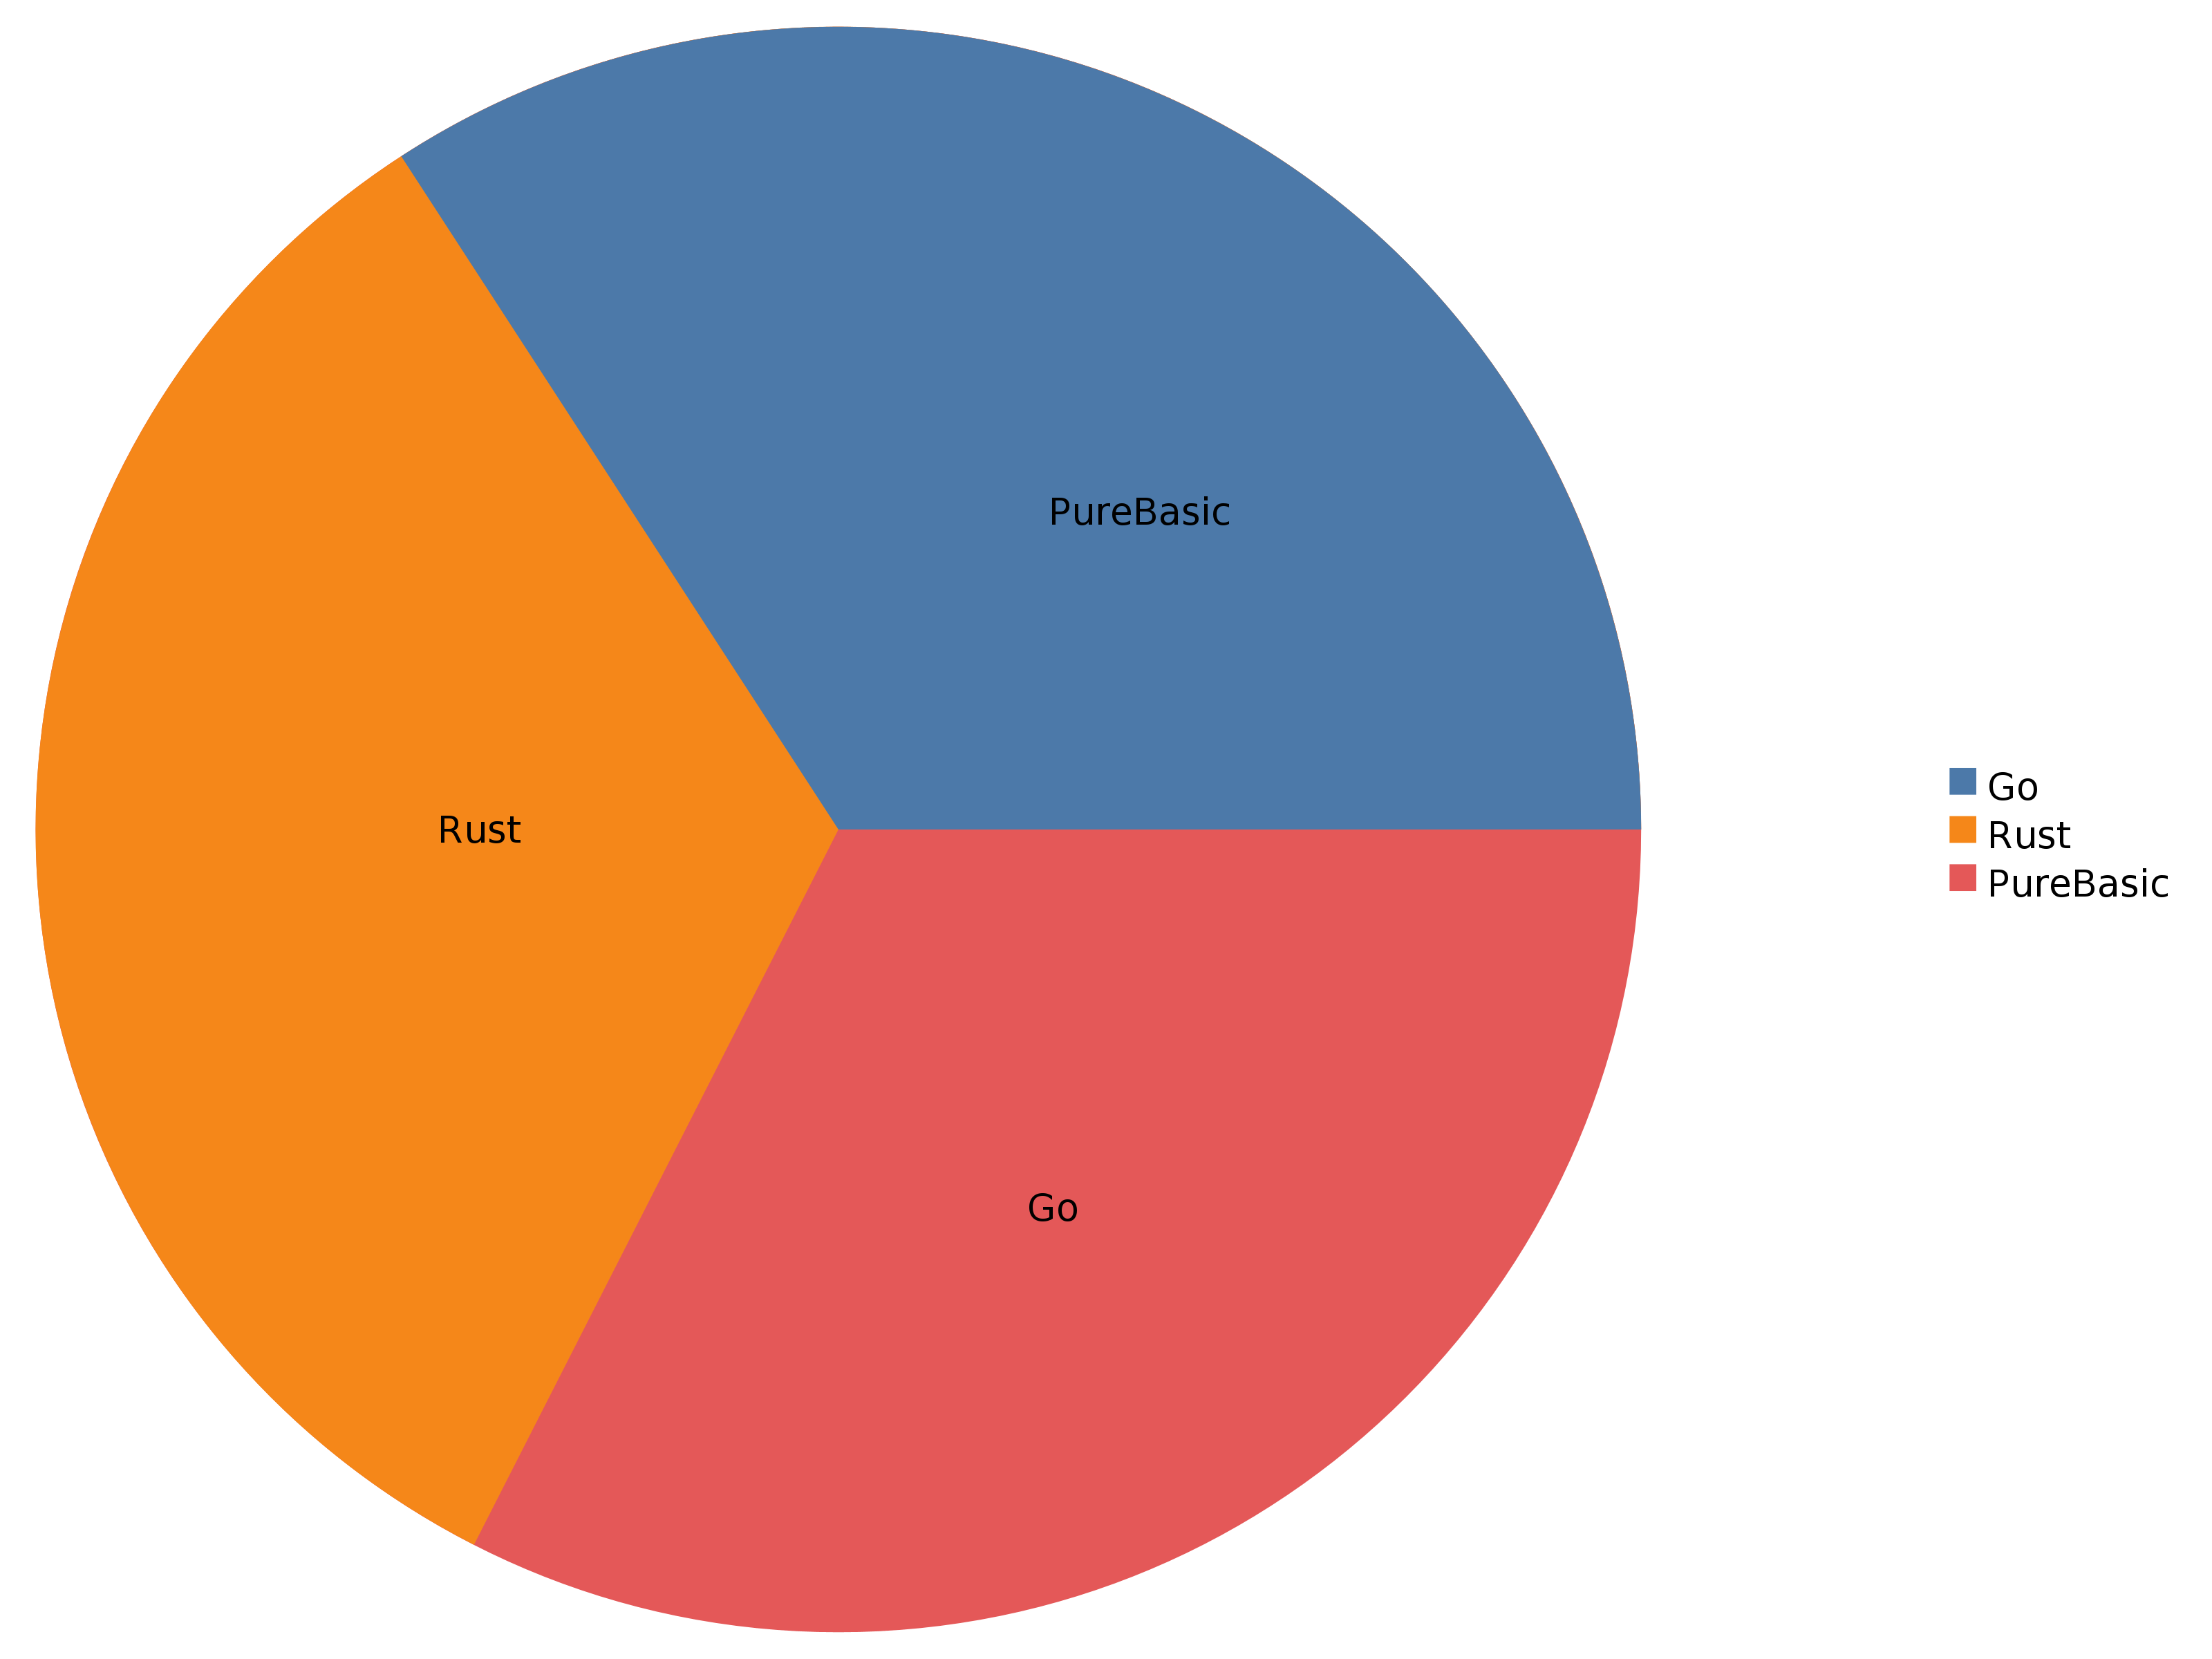

defined function showPlot

In [83]:
def showPlot(plot: com.cibo.evilplot.geometry.Drawable) =
  Image.fromRenderedImage(plot.asBufferedImage, Image.PNG)
showPlot(meanPlot)

In [84]:
val stdDevData = RepresentationService.getStdDev

stdDevData: List[(String, Double)] = List(
  ("TypeScript", 13849.0461258489),
  ("C", 18256.85548160666),
  ("Rust", 34204.512127655165),
  ("Vue", 13841.425504621986),
  ("JavaScript", 19432.04668855984),
  ("Go", 16294.968373004831),
  ("Perl", 3912.5425492894),
  ("Vim script", 8932.586183663241),
  ("PureBasic", 0.0),
  ("Clojure", 11982.752074451753)
)

In [85]:
val drawData: Seq[Double] = stdDevData.map(elem => elem._2).toSeq
val drawLabels: Seq[String] = stdDevData.map(elem => elem._1).toSeq

drawData: Seq[Double] = List(
  13849.0461258489,
  18256.85548160666,
  34204.512127655165,
  13841.425504621986,
  19432.04668855984,
  16294.968373004831,
  3912.5425492894,
  8932.586183663241,
  0.0,
  11982.752074451753
)
drawLabels: Seq[String] = List(
  "TypeScript",
  "C",
  "Rust",
  "Vue",
  "JavaScript",
  "Go",
  "Perl",
  "Vim script",
  "PureBasic",
  "Clojure"
)

In [86]:
val stdDevPlot = BarChart.clustered(Seq(drawData), labels = drawLabels)
                         .xAxis(Seq("10000", "17000"))
                         .yAxis()
                         .frame()
                         .bottomLegend()
                         .render()

stdDevPlot: Drawable = Group(
  Vector(
    Translate(
      StrokeStyle(
        Group(
          Vector(
            Translate(Rotate(Line(561.0, 1.0), 90.0), -0.5000000000000172, 0.0),
            Translate(Line(748.4638671875, 1.0), 0.0, 560.5)
          )
        ),
        HSLA(0.0, 0.0, 12.0, 1.0)
      ),
      51.5361328125,
      0.0
    ),
    Translate(
      Resize(
        Group(
          Vector(
            Translate(
              Style(
                Rect(36.123193359375, 194.23287191503084),
                HSLA(211.0, 38.0, 48.0, 1.0)
              ),
              2.0,
              366.76712808496916
            ),
            Translate(
              Style(
                Rect(36.123193359375, 256.0523981295334),
                HSLA(30.0, 92.0, 53.0, 1.0)
              ),
              39.123193359375,
              304.9476018704666
            ),
            Translate(
              Style(
                Rect(36.123193359375, 479.7182825903637),
          

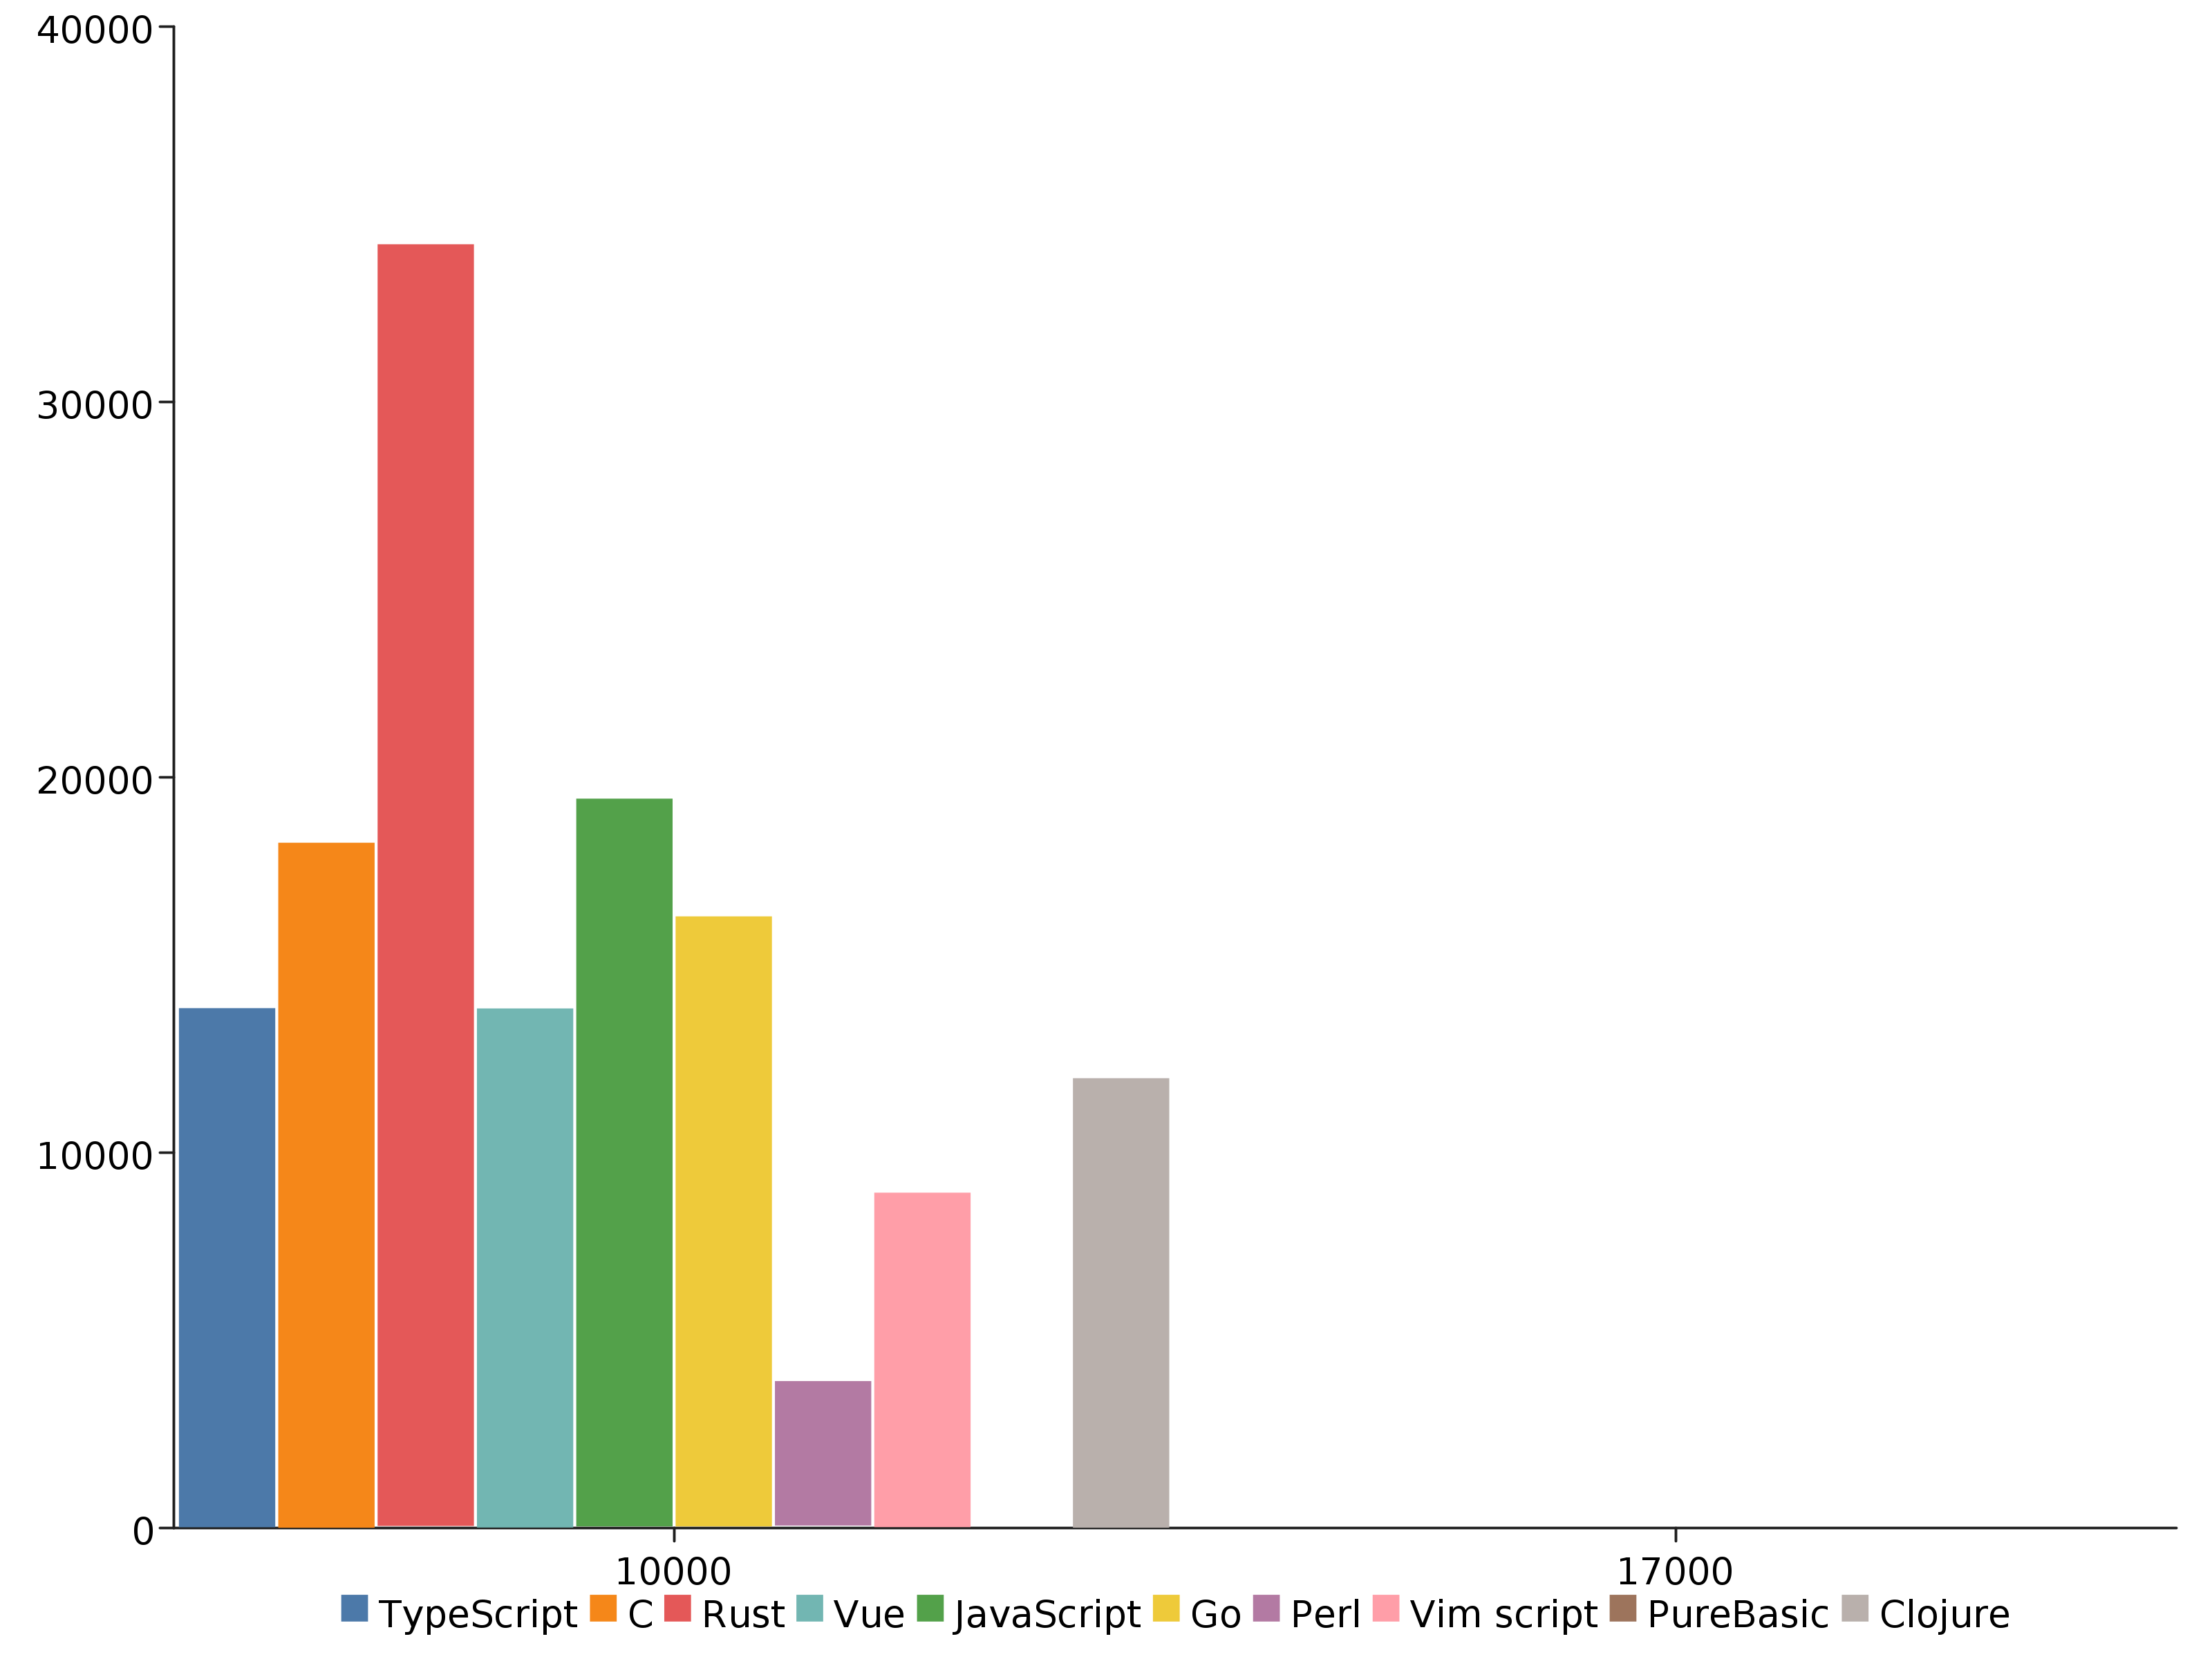

In [87]:
showPlot(stdDevPlot)

In [88]:
val medianData = RepresentationService.getMedian(List("pomadchin", "gvolpe"))

medianData: Map[String, Int] = Map("gvolpe" -> 96, "pomadchin" -> 161)

In [89]:
val medianDrawData = medianData.map(elem => (elem._1, elem._2.toDouble))

val medianPlot = PieChart(medianDrawData.toSeq).rightLegend().render()


medianDrawData: Map[String, Double] = Map(
  "gvolpe" -> 96.0,
  "pomadchin" -> 161.0
)
medianPlot: Drawable = Group(
  Vector(
    Resize(
      Group(
        Vector(
          Style(Wedge(360.0, 300.0), HSLA(30.0, 92.0, 53.0, 1.0)),
          Style(Wedge(134.47470817120623, 300.0), HSLA(211.0, 38.0, 48.0, 1.0)),
          Translate(
            Style(
              Text("gvolpe", 14.0, "sans-serif", None),
              HSLA(0.0, 0.0, 12.0, 1.0)
            ),
            358.0371740721649,
            438.3173395699803
          ),
          Translate(
            Style(
              Text("pomadchin", 14.0, "sans-serif", None),
              HSLA(0.0, 0.0, 12.0, 1.0)
            ),
            241.96282592783504,
            161.68266043001975
          )
        )
      ),
      Extent(703.111328125, 600.0)
    ),
    Translate(
      Group(
        Vector(
          Resize(
            Translate(
              Group(
                Vector(
                  Translate(
         

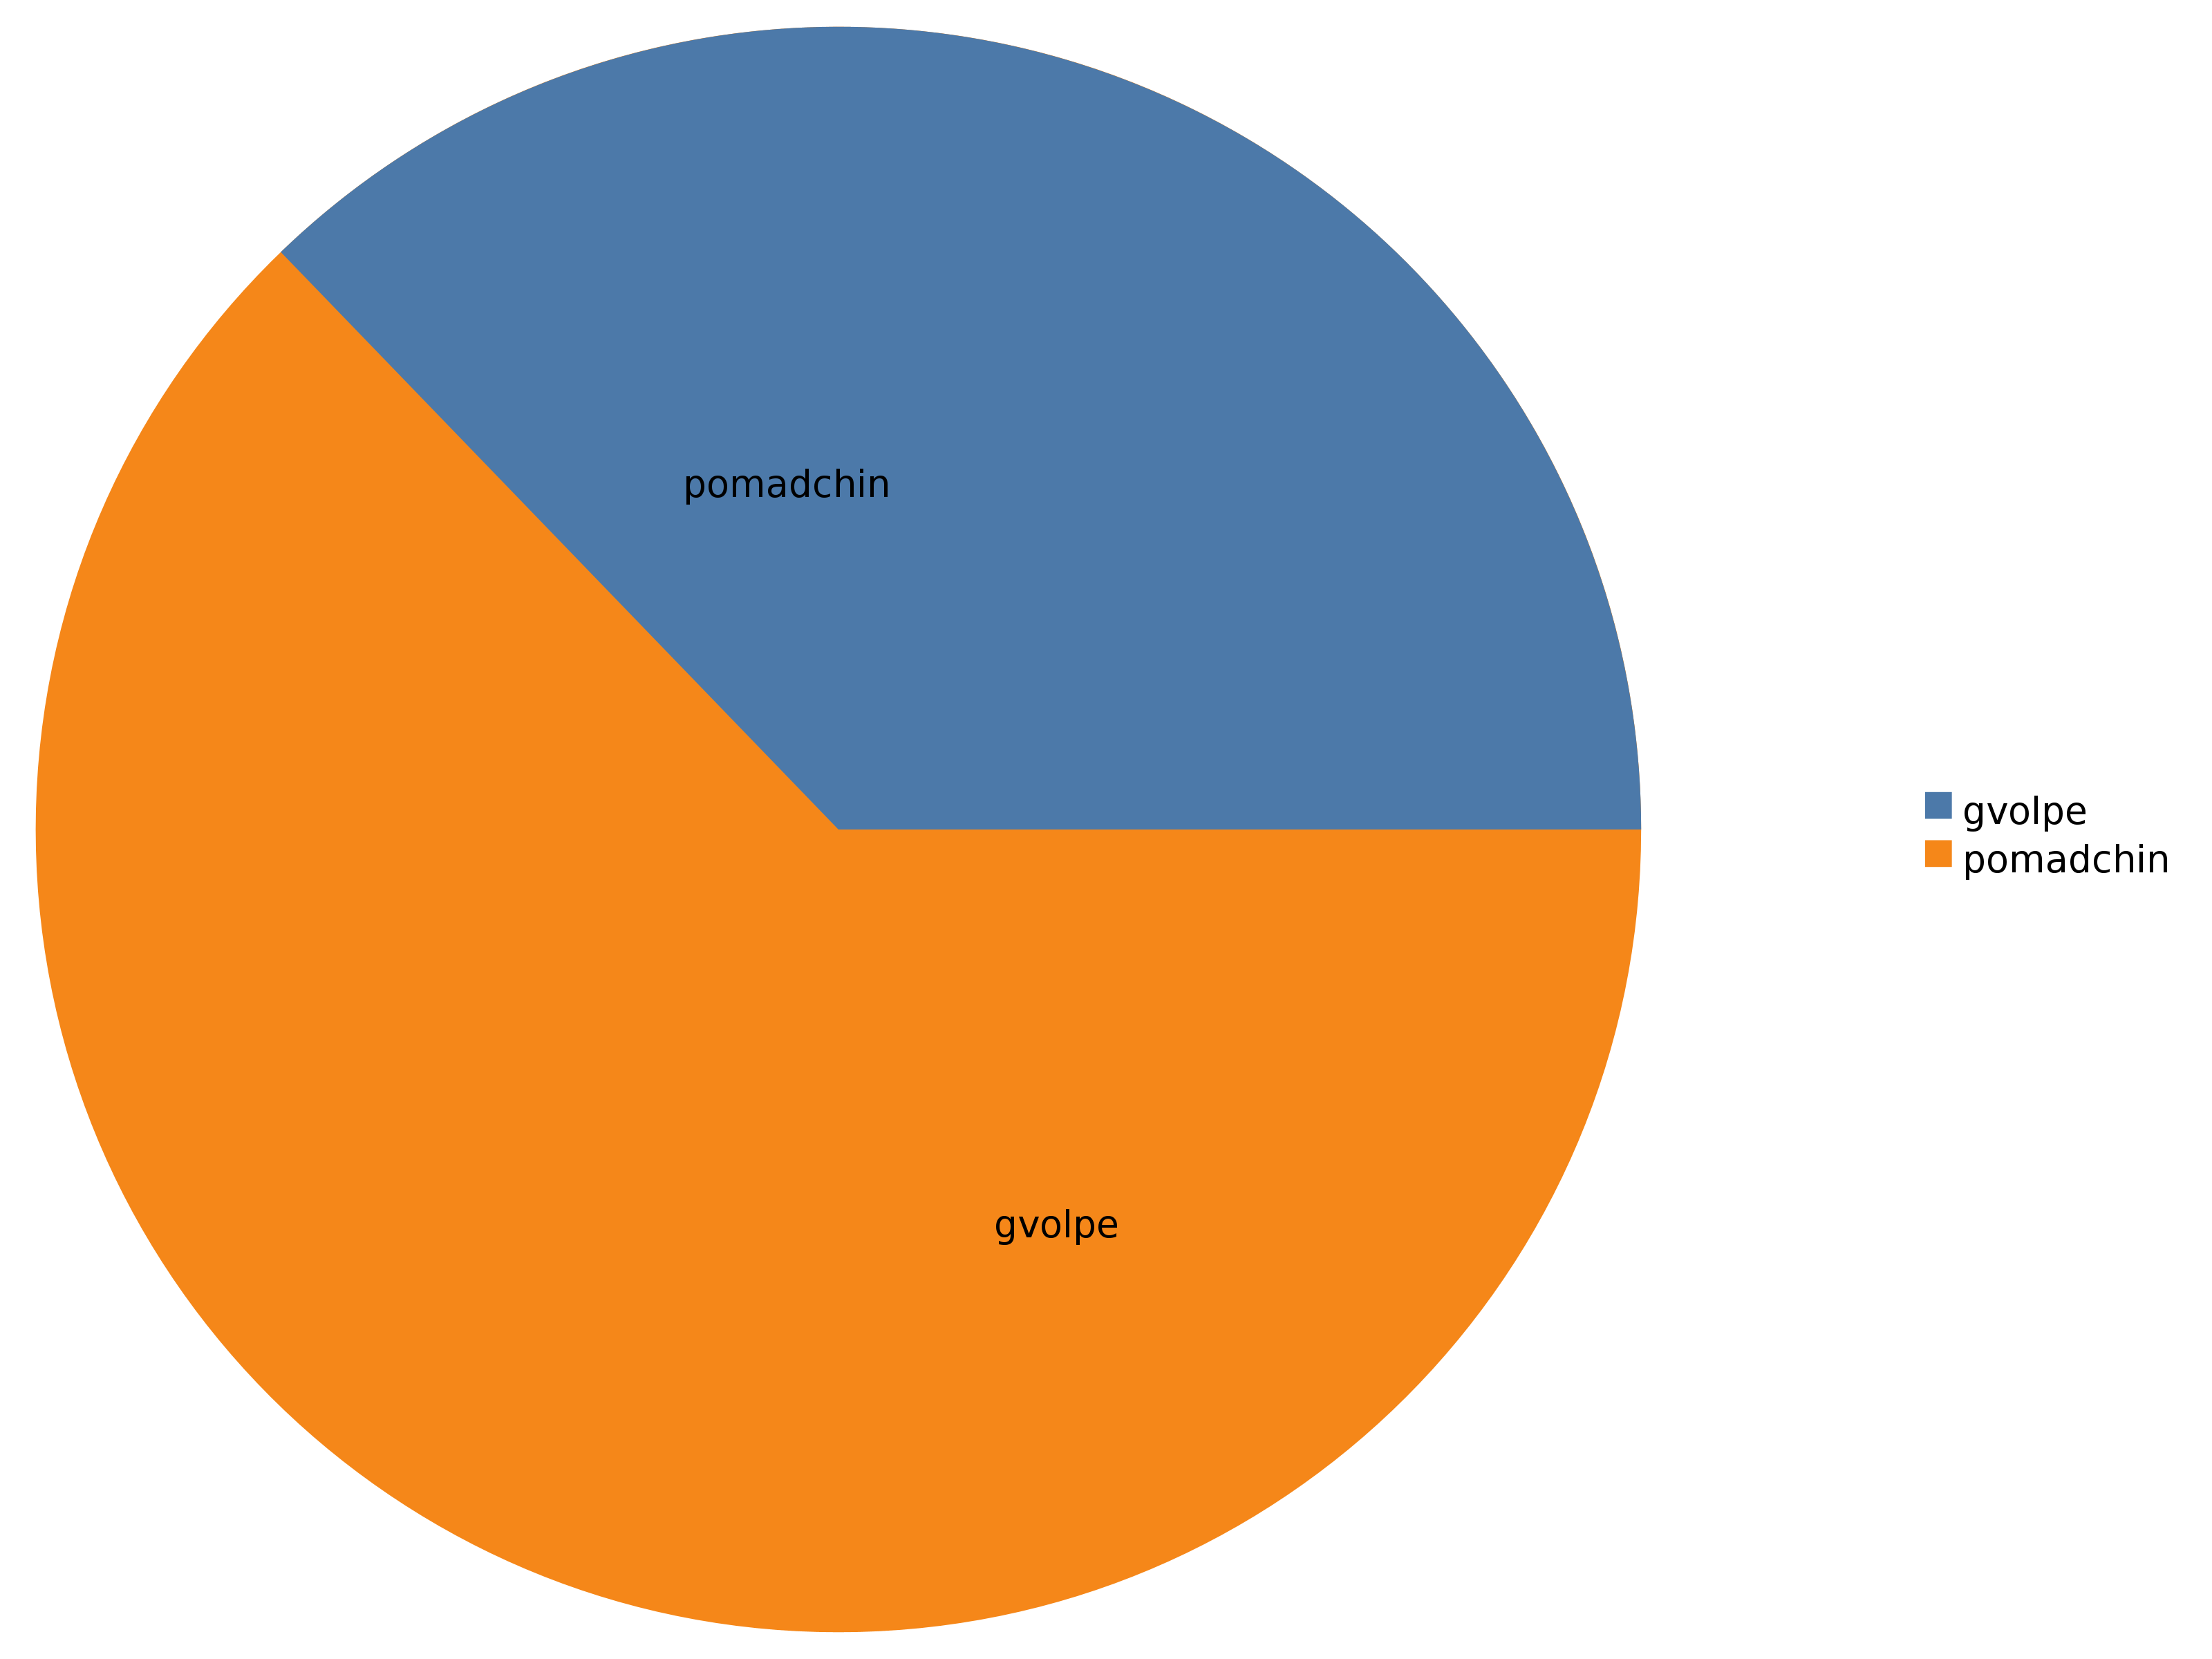

In [90]:
showPlot(medianPlot)

In [91]:
val modeData = RepresentationService.getMode.drop(1).dropRight(1)

modeData: List[(String, Int)] = List(
  ("Vue", 504),
  ("JavaScript", 1627),
  ("PHP", 2557),
  ("Ruby", 1801)
)

In [92]:
val drawModeData: Seq[Double] = modeData.map(elem => elem._2.toDouble).toSeq
val drawModeLabels: Seq[String] = modeData.map(elem => elem._1).toSeq

drawModeData: Seq[Double] = List(504.0, 1627.0, 2557.0, 1801.0)
drawModeLabels: Seq[String] = List("Vue", "JavaScript", "PHP", "Ruby")

In [93]:
val modePlot = BarChart.clustered(Seq(drawModeData), labels = drawModeLabels)
                       .xAxis(Seq("500", "700"))
                       .yAxis()
                       .frame()
                       .bottomLegend()
                       .render()

modePlot: Drawable = Group(
  Vector(
    Translate(
      StrokeStyle(
        Group(
          Vector(
            Translate(Rotate(Line(561.0, 1.0), 90.0), -0.5000000000000172, 0.0),
            Translate(Line(757.37109375, 1.0), 0.0, 560.5)
          )
        ),
        HSLA(0.0, 0.0, 12.0, 1.0)
      ),
      42.62890625,
      0.0
    ),
    Translate(
      Resize(
        Group(
          Vector(
            Translate(
              Style(
                Rect(92.92138671875, 70.68600000000004),
                HSLA(211.0, 38.0, 48.0, 1.0)
              ),
              2.0,
              490.31399999999996
            ),
            Translate(
              Style(
                Rect(92.92138671875, 228.18675000000002),
                HSLA(30.0, 92.0, 53.0, 1.0)
              ),
              95.92138671875,
              332.81325
            ),
            Translate(
              Style(Rect(92.92138671875, 358.61925), HSLA(0.0, 72.0, 62.0, 1.0)),
              189.842773

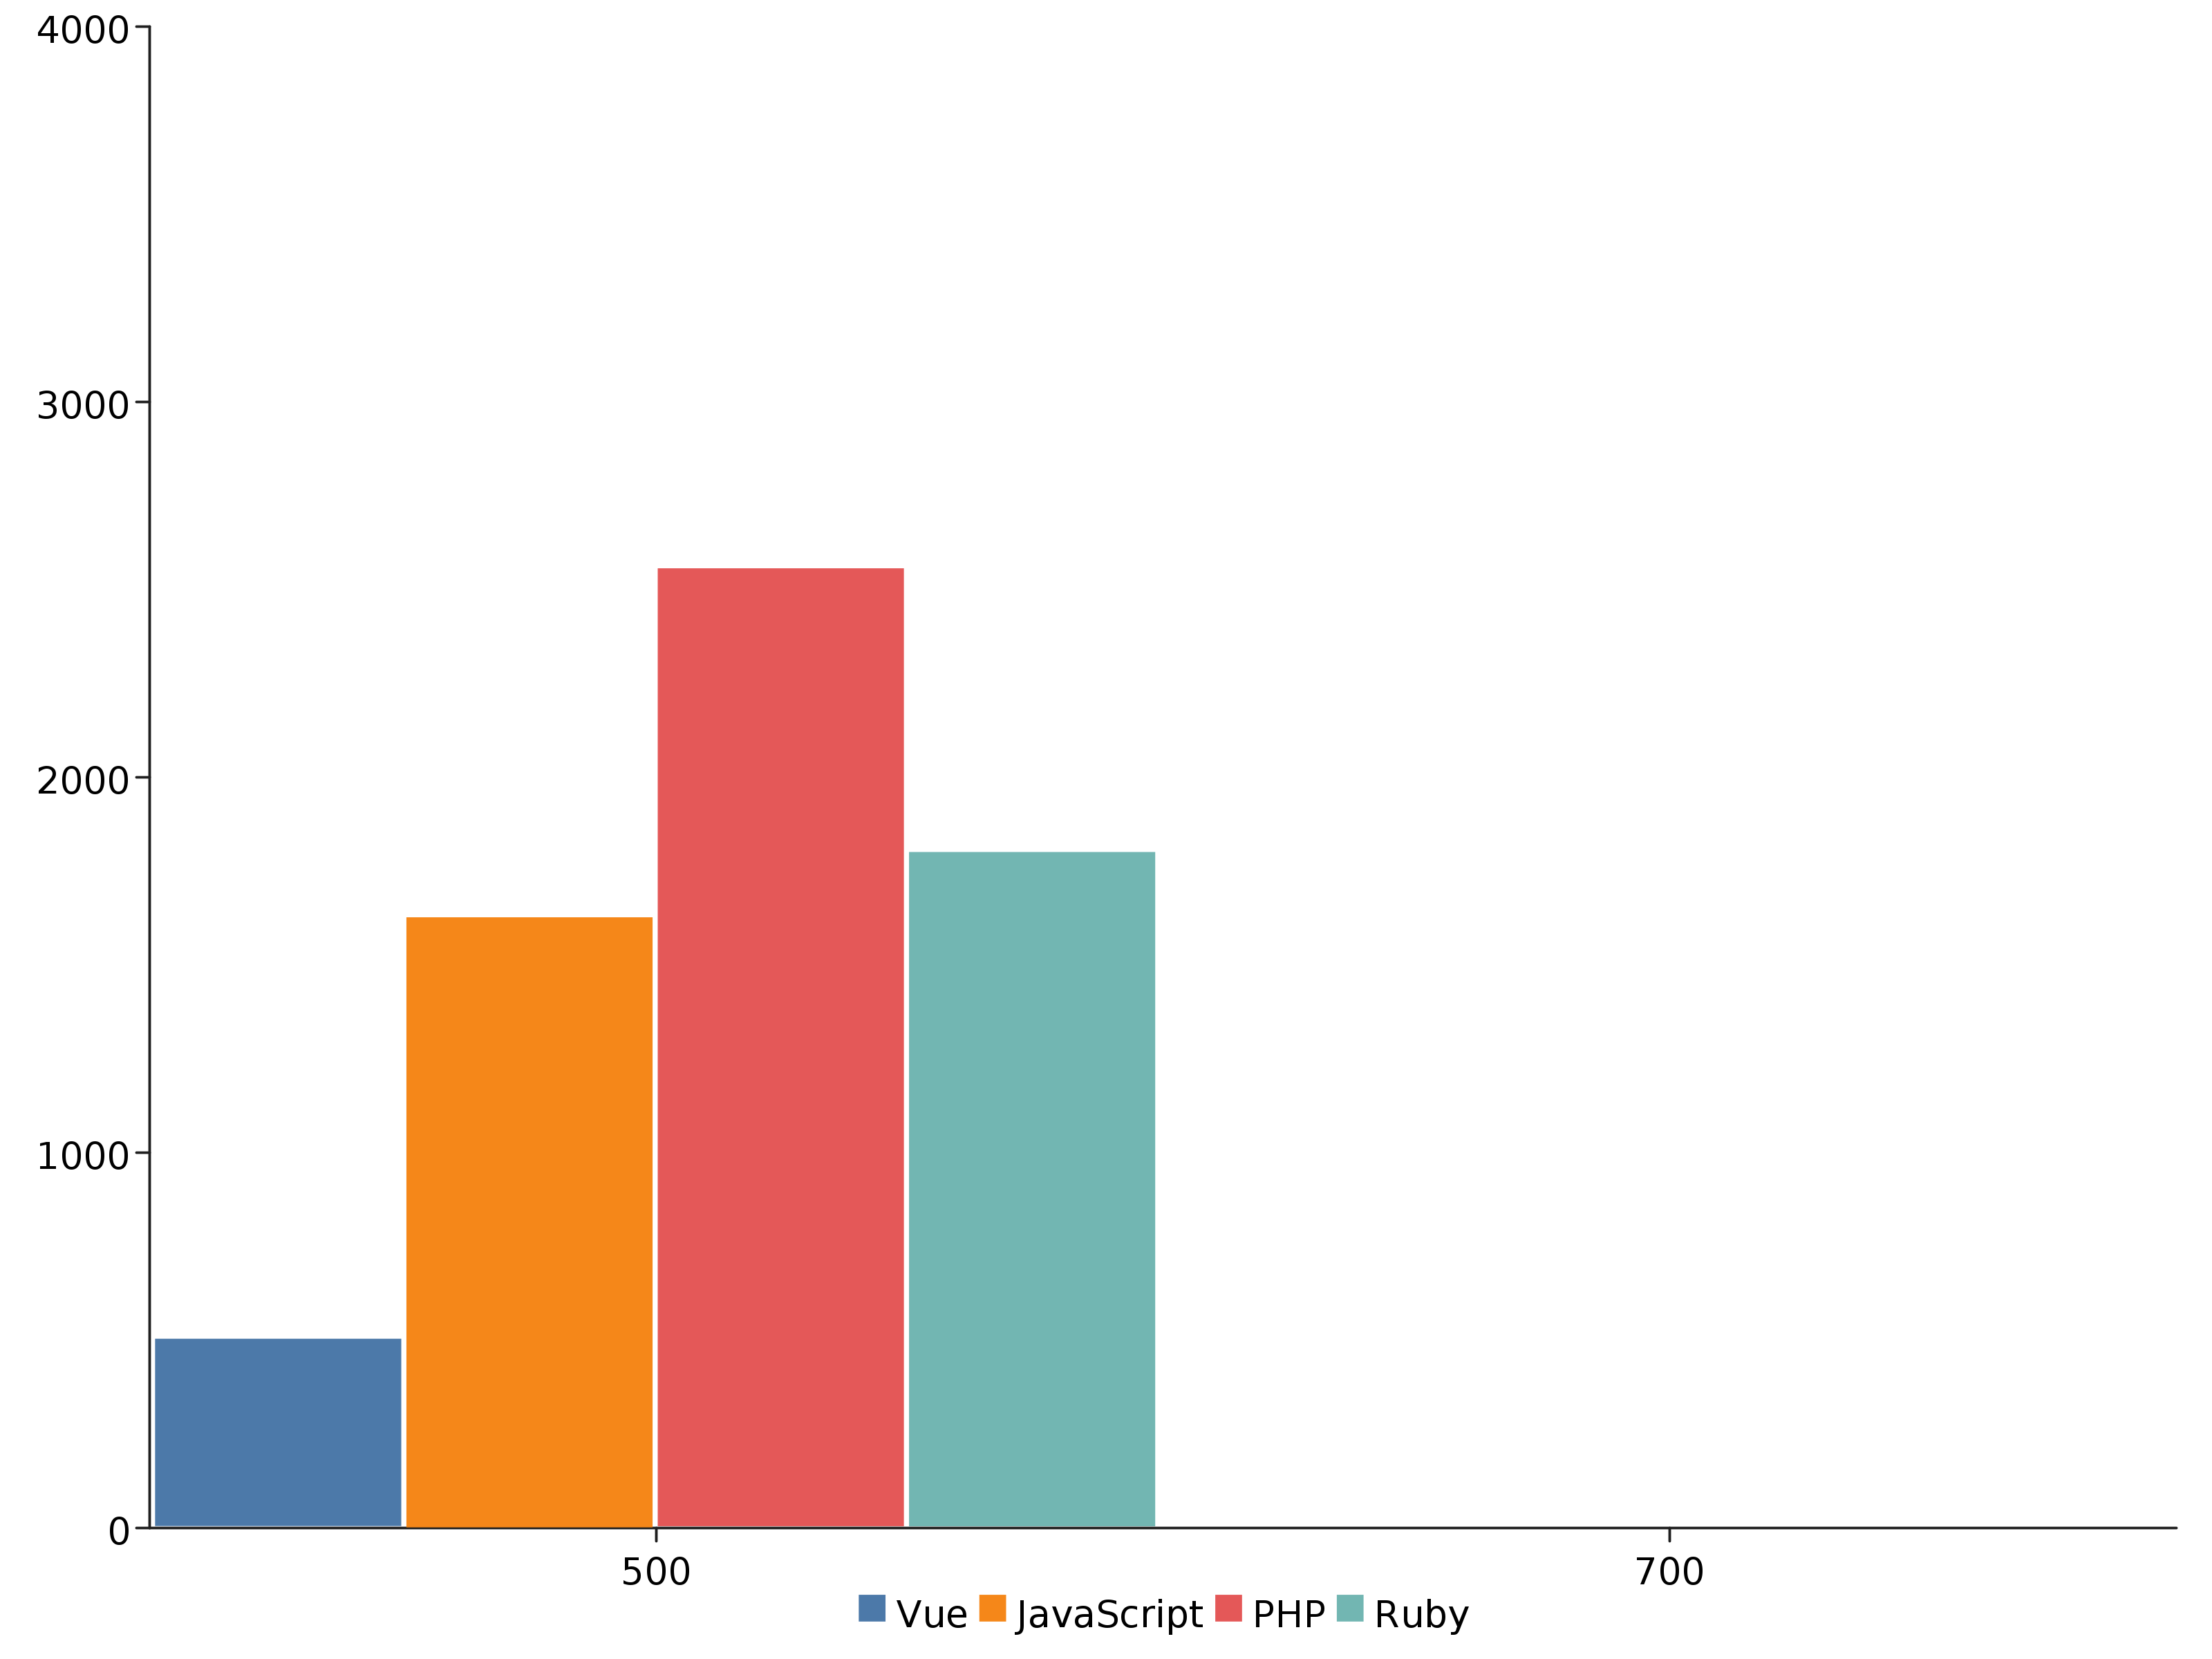

In [94]:
showPlot(modePlot)

In [113]:
def getHistogramm(buckets: Int): Map[String, Seq[Int]] = {
        
        val languages: List[String] = List("roomanidzee", "pomadchin", "gvolpe")
        
        val resultMap: mutable.Map[String, Seq[Int]] = mutable.Map.empty[String, Seq[Int]]
        
        languages.foreach(elem => {            
            val histogramRawData: List[Double] = RepresentationRepository.getUserData(elem)
                                                                         .runSyncUnsafe()
                                                                         .map(_.toDouble)
            
            val max = histogramRawData.max
            val min = histogramRawData.min
            
            val histogram = histogramRawData.map(elem1 => (((elem1 - min)/(max-min))*buckets).floor.toInt)
                                            .groupBy(x=>x)
                                            .map(x=>x._1->x._2.size)
                                            .toSeq
                                            .sortBy(x=>x._1)
                                            .map(x=>x._2)
                                            .drop(1) 
 
            
            resultMap.put(elem, histogram)
            
        })
        
        resultMap.toMap
        
    }

defined function getHistogramm

In [114]:
val histogrammData = getHistogramm(20)

histogrammData: Map[String, Seq[Int]] = Map(
  "roomanidzee" -> List(15, 7, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1),
  "gvolpe" -> List(26, 10, 4, 5, 1, 2, 1, 1, 1, 1),
  "pomadchin" -> List(33, 19, 4, 5, 3, 2, 1, 1, 1, 1, 1, 1)
)

In [115]:
import com.cibo.evilplot.colors.HTMLNamedColors.{green, red, blue}

import com.cibo.evilplot.colors.HTMLNamedColors.{green, red, blue}

In [116]:
import com.cibo.evilplot.plot.renderers.BarRenderer

val histogrammPlot = Overlay(
    Histogram(
      histogrammData("roomanidzee").map(_.toDouble),
      barRenderer = Some(BarRenderer.default(Some(red.copy(opacity = 0.5))))
  ),
  
  Histogram(
      histogrammData("gvolpe").map(_.toDouble),
      barRenderer = Some(BarRenderer.default(Some(green.copy(opacity = 0.5))))
  ),
    
  Histogram(
      histogrammData("pomadchin").map(_.toDouble),
      barRenderer = Some(BarRenderer.default(Some(blue.copy(opacity = 0.5))))
  ) ).standard().render()

import com.cibo.evilplot.plot.renderers.BarRenderer


histogrammPlot: Drawable = Group(
  Vector(
    Translate(
      StrokeStyle(
        Group(
          Vector(
            Translate(Rotate(Line(579.0, 1.0), 90.0), -0.5000000000000178, 0.0),
            Translate(Line(761.828125, 1.0), 0.0, 578.5)
          )
        ),
        HSLA(0.0, 0.0, 12.0, 1.0)
      ),
      38.171875,
      0.0
    ),
    Translate(
      Group(
        Vector(
          Translate(
            Rotate(
              StrokeStyle(Line(579.0, 0.25), HSLA(0.0, 0.0, 65.0, 0.8)),
              90.0
            ),
            -0.12500000000001774,
            0.0
          ),
          Translate(
            Rotate(
              StrokeStyle(Line(579.0, 0.25), HSLA(0.0, 0.0, 65.0, 0.8)),
              90.0
            ),
            190.33203124999997,
            0.0
          ),
          Translate(
            Rotate(
              StrokeStyle(Line(579.0, 0.25), HSLA(0.0, 0.0, 65.0, 0.8)),
              90.0


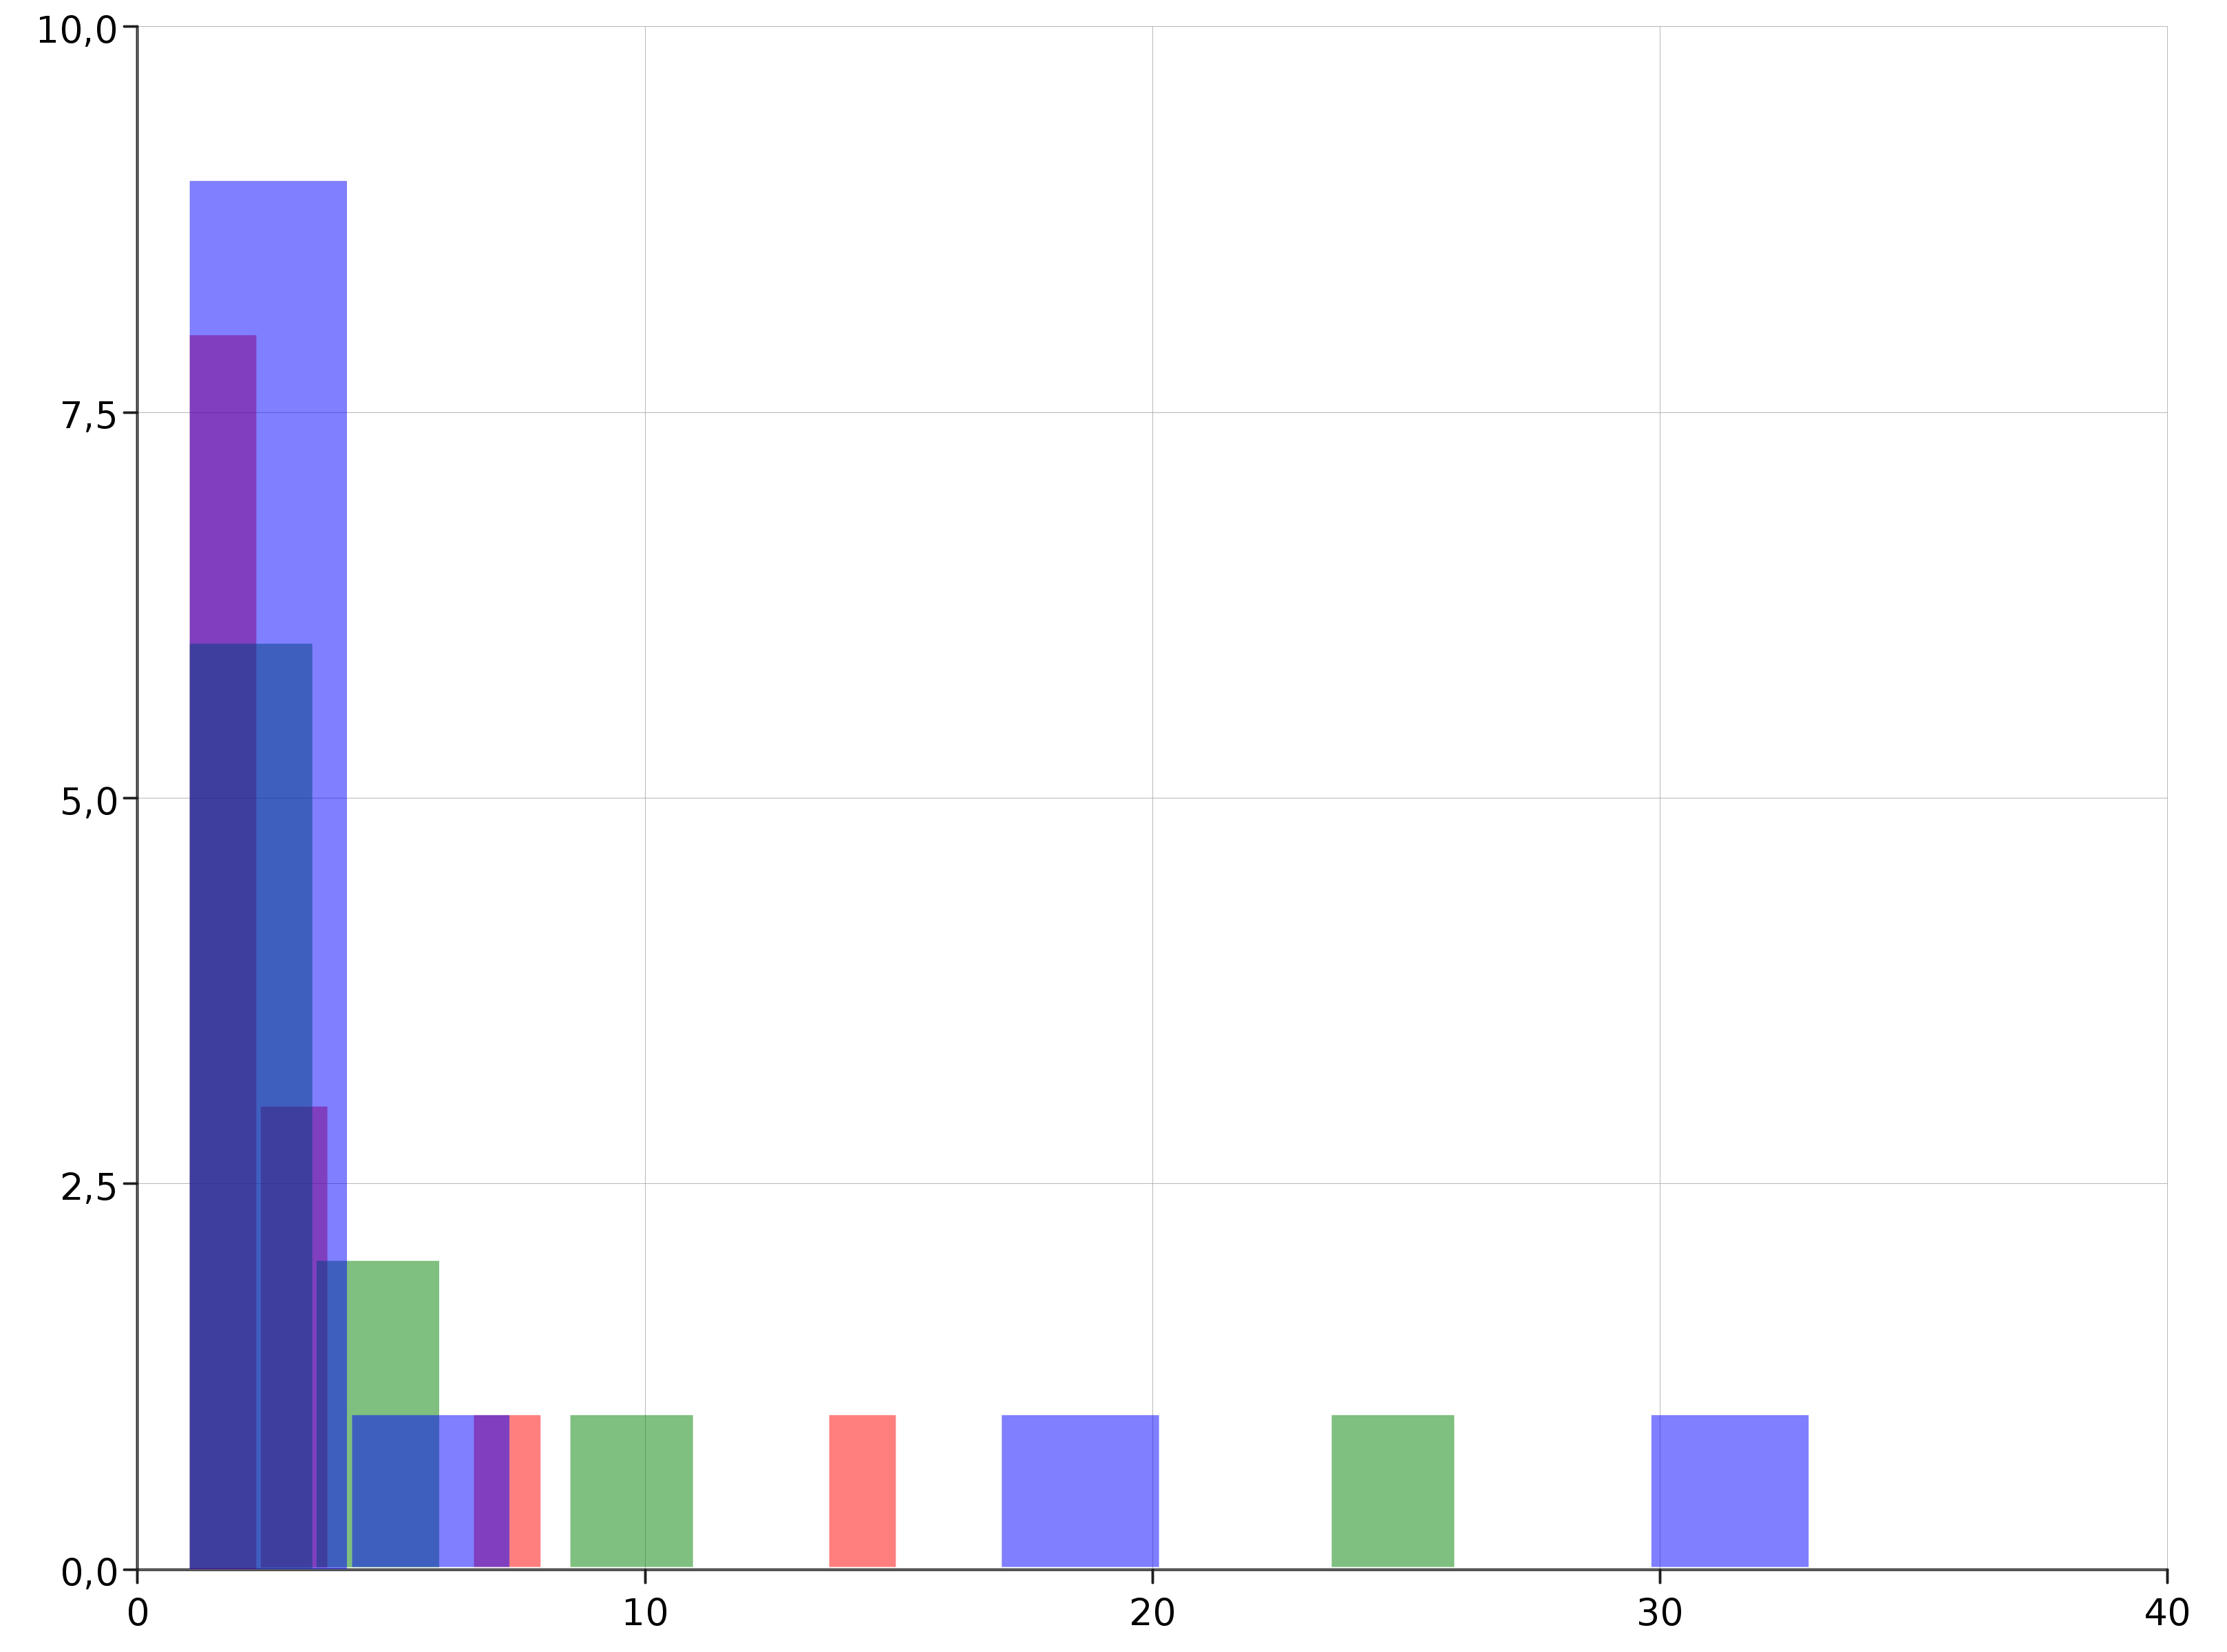

In [117]:
showPlot(histogrammPlot)